<h1>Network Model</h1>

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd
import datetime
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm

In [2]:
class agent:
    
    def __init__ (self, x, y):
        self.x = x
        self.y = y
        self.mobility = np.random.random()
        self.contacts = []
        self.status = 's'
    
    def infect(self):
        if self.status == 's':
            self.status = 'i'
    
    def recover(self):
        if self.status == 'i':
            self.status = 'r'
    
def logistic(x):
    return np.exp(x)/(1+np.exp(x))
    
def distance(r):
    return np.sqrt((self.x-r[0])**2+(self.y-r[1])**2)

def census(population):
    
    #create an array of statuses
    statuses = np.array([individual.status for individual in population])

    #vectorized for loops counting statuses 
    s = np.sum(statuses == 's')
    i = np.sum(statuses == 'i')
    r = np.sum(statuses == 'r')
    
    return np.array([s, i, r])


def epidemic1D(pt,population):

    N = population.size
    
    for n in range(N):
        
        #check if the indidual is infected
        if population[n].status=='i':
            
            #infect the susceptible others with a certain probability
            for index in population[n].contacts:
                indicies = np.random.rand()
                if np.random.rand()<pt:
                    population[index].infect()
                    
            #put the infected individual in the recovered state
            population[n].recover()
            
    return population
            

def simulate1D(pt, N, total_population):
    
    #list of the sir populations by week
    sir = []
    
    #creates an array of the class agent
    radius = 2
    network_parameter = 2
    population_centers = np.array([ [20*np.random.random(),20*np.random.random()] for n in range(total_population) ])
    indices = np.random.choice(N,size=total_population)
    individual_locations = population_centers[indices]+np.random.normal(0,radius,(total_population,2))
    xs = individual_locations[:,0]
    ys = individual_locations[:,1]
    population = np.array([agent(xs[n], ys[n]) for n in range(total_population)])
    
    #create network
    for n in range(total_population):
        for m in range(total_population):
            d = np.sqrt((population[n].x-population[m].x)**2+(population[n].y-population[m].y)**2)
            log = np.exp(-d/population[n].mobility*network_parameter)/(1+np.exp(-d/population[n].mobility*network_parameter))
            if np.random.random() < log and d > 0.00001:
                population[n].contacts.append(m)
                population[m].contacts.append(n)
    
    #randomly infect 10 percent
    indices = np.random.choice(np.arange(total_population),total_population//100,replace=False)
    for index in indices:
        population[index].infect()
        
    #record initial populations
    state = census(population)
    sir.append(state)
    
    #simulate the remaining weeks
    while state[1]>0:
        new_population=epidemic1D(pt,population)
        state = census(new_population)
        sir.append(state)
        population = new_population
        
    return np.array(sir), population, individual_locations

In [3]:
total_population = 100
N = 5
radius = 0.2
sir, population, locations = simulate1D(0.3, 5, 1000)

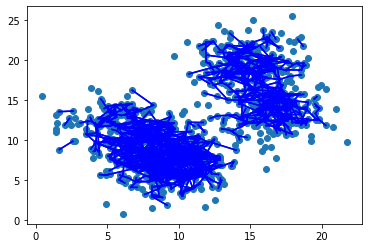

In [4]:
plt.scatter(locations[:,0],locations[:,1])
for pupil in population:
    for contact in pupil.contacts:
        friend = population[contact]
        plt.plot([pupil.x,friend.x],[pupil.y,friend.y],color='b')

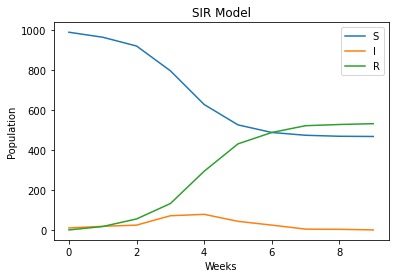

In [5]:
# plot results
t = np.arange(len(sir[:,0]))
plt.plot(t, sir[:,0], label="S")
plt.plot(t, sir[:,1], label="I")
plt.plot(t, sir[:,2], label="R")
plt.legend()
plt.title('SIR Model')
plt.xlabel('Weeks')
plt.ylabel('Population')
plt.show()

<h1>Network SIR Hybrid Model</h1>

$${ \frac{dS_i}{dt} = -\frac{S_i}{N} \sum_{j} \beta_{ij} I_j \\ \frac{dI_i}{dt} = \frac{S_i}{N} \sum_{j} \beta_{ij} I_j  - \gamma_i I \\ \frac{dR}{dt} = \gamma_i I}$$
with loss function
$$L = \left(-\frac{S_i}{N} \sum_{j} \beta_{ij} I_j + \frac{\hat{S}_i}{N} \sum_{j} \beta_{ij} \hat{I}_j\right)^2 + \left(\frac{S_i}{N} \sum_{j} \beta_{ij} I_j - \gamma_i I - \frac{\hat{S}_i}{N} \sum_{j} \beta_{ij}  \hat{I}_j + \gamma_i \hat{I}\right)^2 + \left(\gamma_i I - \gamma_i \hat{I}\right)^2$$

In [273]:
def census(sir):
    s = np.sum(sir[:,0])
    i = np.sum(sir[:,1])
    r = np.sum(sir[:,2])
    return np.array([s, i, r])

def loss_function(sir, df, state_data, weights, date):
    loss = 0
    state_list = df['State or territory'].to_numpy()
    sir_data = np.zeros_like(sir)
    grads = {'alpha':np.zeros((51,51)), 'beta':np.zeros((51,51)), 'gamma':np.zeros((51,51))}
    beta = weights['beta']
    gamma = weights['gamma']
    N = np.sum(sir)
    for n in range(len(state_list)):
        state = state_list[n]
        state_df = state_data[state]
        #get population in state
        population = int(df[df['State or territory'] == state].iloc[0,3])
        #get positive from data
        positive_data = state_df[state_df['date']==date].positive.to_numpy()[0]
        #get recovered from data
        recovered_data = state_df[state_df['date']==date].recovered.to_numpy()[0]+state_df[state_df['date']==date].death.to_numpy()[0]
        sir_data[n,0] = population - positive_data
        sir_data[n,1] = positive_data - recovered_data
        sir_data[n,2] = recovered_data
    loss += np.sum((beta/N*(sir_data[:,1]*sir_data[:,0]-sir[:,1]*sir[:,0]))**2)
    loss += np.sum((beta/N*(-sir_data[:,1]*sir_data[:,0]+sir[:,1]*sir[:,0])+\
             gamma*(sir_data[:,1]-sir[:,1]))**2)
    loss += np.sum((gamma*(sir_data[:,1]-sir[:,1]))**2)
    grads['beta'] = -2*(np.outer(sir[:,0],sir[:,1])-np.outer(sir_data[:,0],sir_data[:,1]))**2*beta/N**2
    grads['gamma'] = (4*gamma*(sir[:,1]-sir_data[:,1])**2/
        +2*(-sir[:,1]+sir_data[:,1])*\
        (sir[:,0]*np.matmul(beta,sir[:,1])/N-sir_data[:,0]*np.matmul(beta,sir_data[:,1])/N))
    return loss, grads

def update_populations(sir, weights, dt):
    beta = weights['beta']
    gamma = weights['gamma']
    N = np.sum(sir)
    return_sir = sir.copy()
    return_sir[:,0] += -sir[:,0]*np.matmul(beta,sir[:,1])*dt/N
    return_sir[:,1] += sir[:,0]*np.matmul(beta,sir[:,1])*dt/N - gamma*sir[:,1]*dt
    return_sir[:,2] += gamma*sir[:,1]*dt
    return return_sir

def run_simulation(dt, trials=10, learning_rate=0.001):
    
    start_date = '2020-05-01'
    end_date = '2020-06-01'

    start_time = datetime.datetime.strptime(start_date,'%Y-%m-%d')
    end_time = datetime.datetime.strptime(end_date,'%Y-%m-%d')
    cycles = int((end_time-start_time).total_seconds()/dt)
    
    url = 'https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States_by_population'
    file = urllib.request.urlopen(url).read()
    tables = str(file).split('<table')
    for table in tables:
        if '39,368,078' in table:
            pop_table = '<table'+table.split('table>')[0]+'table>'
            pop_table = pop_table.replace('\\n','')
            df = pd.read_html(pop_table)[0]
            df.columns = df.columns.get_level_values(1)
    
    df = df[df['State or territory'] !='Puerto Rico']
    df = df[df['State or territory'] !='Guam']
    df = df[df['State or territory'] !='U.S. Virgin Islands']
    df = df[df['State or territory'] !='Northern Mariana Islands']
    df = df[df['State or territory'] !='American Samoa']
    df = df[df['State or territory'] !='Contiguous United States']
    df = df[df['State or territory'] !='The fifty states and D.C.']
    df = df[df['State or territory'] !='Total United States']
    df = df[df['State or territory'] !='The fifty states']
    
    states = df['State or territory'].to_numpy()
    
    weights = {'beta':np.random.random((len(states),len(states)))/10**7, 'gamma':np.random.random(len(states))/10**9}
    
    states_data = {}
    for state in states:
        states_data[state] = pd.read_csv('C:/Users/bentr/Documents/harvard/MathematicalModeling/Project_1/Data/'\
            +state.lower().replace(' ','-')+'-history.csv').fillna(0)
    
    loss = np.zeros(trials)
    
    for trial in tqdm(range(trials)):
        
        sir = np.zeros((df.shape[0],3),dtype=float)
        sir[:,0] = df['EstimatedJuly 1, 2020[6]'].to_numpy(dtype=float)
    
        for n in range(len(states)):
            state_data = states_data[states[n]]
            positive = state_data[state_data['date']==start_date].positive.to_numpy(dtype=float)[0]
            recovered = state_data[state_data['date']==start_date].recovered.to_numpy(dtype=float)[0]
            sir[n,0] += -positive  
            sir[n,1] += positive - recovered
            sir[n,2] += recovered
            
        for cycle in range(cycles):
            sir = update_populations(sir, weights, dt)
            
        trial_loss, grads = loss_function(sir, df, states_data, weights, end_date)
        
        weights['beta'] -= learning_rate*grads['beta']
        weights['gamma'] -= learning_rate*grads['gamma']
        loss[trial] = trial_loss
    
    start_date = '2020-05-01'
    end_date = '2020-07-01'

    start_time = datetime.datetime.strptime(start_date,'%Y-%m-%d')
    end_time = datetime.datetime.strptime(end_date,'%Y-%m-%d')
    cycles = int((end_time-start_time).total_seconds()/dt)
    
    sir[:,0] = df['EstimatedJuly 1, 2020[6]'].to_numpy(dtype=float)
    
    return_sir = np.zeros((cycles,3))
    
    for n in range(len(states)):
        state_data = states_data[states[n]]
        positive = state_data[state_data['date']==start_date].positive.to_numpy(dtype=float)[0]
        recovered = state_data[state_data['date']==start_date].recovered.to_numpy(dtype=float)[0]
        sir[n,0] += -positive  
        sir[n,1] += positive - recovered
        sir[n,2] += recovered
        
    return_sir[0,0] = np.sum(sir[:,0])
    return_sir[0,1] = np.sum(sir[:,1])
    return_sir[0,2] = np.sum(sir[:,2])
    
    for cycle in range(cycles):
        sir = update_populations(sir, weights, dt)
        return_sir[cycle] = census(sir)
        
    return return_sir, loss, weights
        

In [274]:
sir, loss, weights = run_simulation(200,trials=15,learning_rate=10**-12)

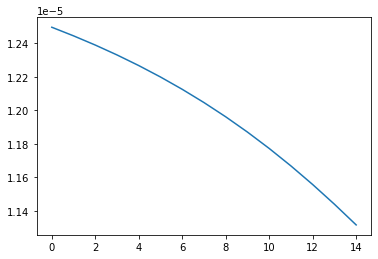

In [275]:
plt.plot(np.arange(len(loss)),loss)

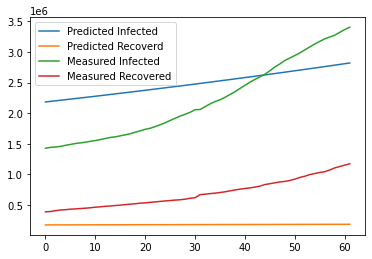

In [276]:
start_date = '2020-05-01'
end_date = '2020-07-01'

url = 'https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States_by_population'
file = urllib.request.urlopen(url).read()
tables = str(file).split('<table')
for table in tables:
    if '39,368,078' in table:
        pop_table = '<table'+table.split('table>')[0]+'table>'
        pop_table = pop_table.replace('\\n','')
        df = pd.read_html(pop_table)[0]
df.columns = df.columns.get_level_values(1)

df = df[df['State or territory'] !='Puerto Rico']
df = df[df['State or territory'] !='Guam']
df = df[df['State or territory'] !='U.S. Virgin Islands']
df = df[df['State or territory'] !='Northern Mariana Islands']
df = df[df['State or territory'] !='American Samoa']
df = df[df['State or territory'] !='Contiguous United States']
df = df[df['State or territory'] !='The fifty states and D.C.']
df = df[df['State or territory'] !='Total United States']
df = df[df['State or territory'] !='The fifty states']

start_time = datetime.datetime.strptime(start_date,'%Y-%m-%d')
end_time = datetime.datetime.strptime(end_date,'%Y-%m-%d')
cycles = int((end_time-start_time).total_seconds()/dt)

states = df['State or territory'].to_numpy()

states_data = {}
for state in states:
    states_data[state] = pd.read_csv('C:/Users/bentr/Documents/harvard/MathematicalModeling/Project_1/Data/'\
        +state.lower().replace(' ','-')+'-history.csv').fillna(0)


dates = states_data['Arizona'].date[217:279].to_numpy()
sir_data = np.zeros((len(dates),2))
#sir_data[0,0] = np.sum(df['EstimatedJuly 1, 2020[6]'].to_numpy(dtype=float)) 

for d in range(len(dates)):
    date = dates[d]
    for n in range(len(states)):
        state_data = states_data[states[n]]
        positive = state_data[state_data['date']==date].positive.to_numpy(dtype=float)[0]
        recovered = state_data[state_data['date']==date].recovered.to_numpy(dtype=float)[0]
        sir_data[len(dates)-1-d,0] += positive - recovered
        sir_data[len(dates)-1-d,1] += recovered
        
time = np.arange(0,len(sir[:,0])*200,200)/24/3600
#plt.plot(time,sir[:,0])
plt.plot(time,sir[:,1],label="Predicted Infected")
plt.plot(time,sir[:,2],label="Predicted Recoverd")
plt.plot(np.arange(len(dates)),sir_data[:,0],label="Measured Infected")
plt.plot(np.arange(len(dates)),sir_data[:,1],label="Measured Recovered")
plt.legend()

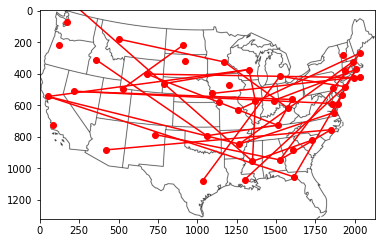

In [296]:
def r(l):
    lon, lat = l
    y = 3.53545999e-01*lat**2 - 1.09993007e-01*lon**2\
    -1.17889646e-01*lat*lon - 6.88413422e+01*lat\
    +2.53770516e+01*lon + 1.74488695e+03
    x =-6.23421581e-01*lat**2 +  1.71644223e-02*lon**2+\
    +6.43396983e-01*lat*lon - 1.65264449e+01*lat + \
    -6.70263977e+01*lon + 6.55819583e+03 
    return np.array([x,y])

lonlat=np.array([[123, 97, 84, 73, 76, 89, 83, 84, 78, 84,\
                 74, 77, 122, 112, 71, 86, 86, 92, 76, 89,\
                 107, 93, 81, 86, 91, 84, 123, 97, 72, 111,\
                 93, 119, 92, 90, 95, 105, 96, 116, 81, 121,\
                 71, 69, 112, 71, 75, 100, 100, 122, 77, 72,\
                 104],\
                 [38, 30, 30, 42, 40, 39, 39, 33, 35, 42,\
                 40, 37, 47, 33, 42, 36, 39, 38, 38, 43,\
                 42, 44, 34, 32, 30, 38, 44, 35, 41, 40,\
                 41, 39, 34, 32, 39, 35, 40, 43, 10, 35,\
                 43, 44, 46, 41, 39, 44, 46, 50, 38, 44,\
                 41]])

locations = r(lonlat)
img=plt.imread('usa.jpg')
b_cutoff = np.max(weights['beta'])*0.99
for i in range(len(states)):
    for j in range(len(states)):
        if weights['beta'][i,j]>b_cutoff:
            x1=lonlat[0][i]
            y1=lonlat[1][i]
            x2=lonlat[0][j]
            y2=lonlat[1][j]
            points = r(np.array([[x1,x2],[y1,y2]]))
            plt.plot(points[0],points[1],color='r')
        
plt.scatter(locations[0],locations[1], color='r')
plt.imshow(img, cmap="gray")